In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from fastai import *
from fastai.vision import *
from ArNet.generators import *
from ArNet.critics import *
from ArNet.dataset import *
from ArNet.loss import *
from ArNet.save import *
from ArNet.fid_loss import *
from ArNet.ssim import *
from ArNet.metrics import *

import torchvision
import geffnet # efficient/ mobile net

In [2]:
def do_fit(learn, epochs,save_name, lrs=slice(1e-3), pct_start=0.3):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save("/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/" + save_name)
    learn.show_results(rows=1, imgsize=10)

In [3]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'

path_lowRes_256 = path/'DIV2K_train_LR_256_QF20'
path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
path_lowRes_Full = path/'DIV2K_train_LR_Full_QF20'

proj_id = 'unet_superRes_mobilenetV3_MSE'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

nf_factor = 2
pct_start = 1e-8

In [4]:
model = geffnet.mobilenetv3_rw

In [5]:
# loss_func = FeatureLoss()
# loss_func = msssim
# loss_func = fid
loss_func = nn.MSELoss()

# 256px

In [6]:
bs=4
sz=256
lr = 1e-2
wd = 1e-3
epochs = 1

In [7]:
data_gen = get_DIV2k_data_QF(path_lowRes_256, path_fullRes, bs=bs, sz=sz)

In [8]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [11]:
learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())
learn_gen.metrics.append(LPIPS_Metric_gen())
learn_gen.metrics.append(LPIPS_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [10]:
wandbCallbacks = False

if wandbCallbacks:
    import wandb
    from wandb.fastai import WandbCallback
    config={"batch_size": bs,
            "img_size": (sz, sz),
            "learning_rate": lr,
            "weight_decay": wd,
            "num_epochs": epochs
    }
    wandb.init(project='SuperRes', config=config, id="unet_superRes_mobilenetV3_FID"+ datetime.now().strftime('_%m-%d_%H:%M'))

    learn_gen.callback_fns.append(partial(WandbCallback, input_type='images'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


DynamicUnetWide
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 128, 128]       432        False     
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
HardSwish            [16, 128, 128]       0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       144        False     
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
ReLU                 [16, 128, 128]       0          False     
______________________________________________________________________
Identity             [16, 128, 128]       0          False     
______________________________________________

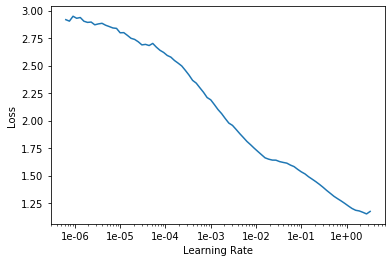

In [14]:
learn_gen.lr_find()
learn_gen.recorder.plot()
learn_gen.summary()

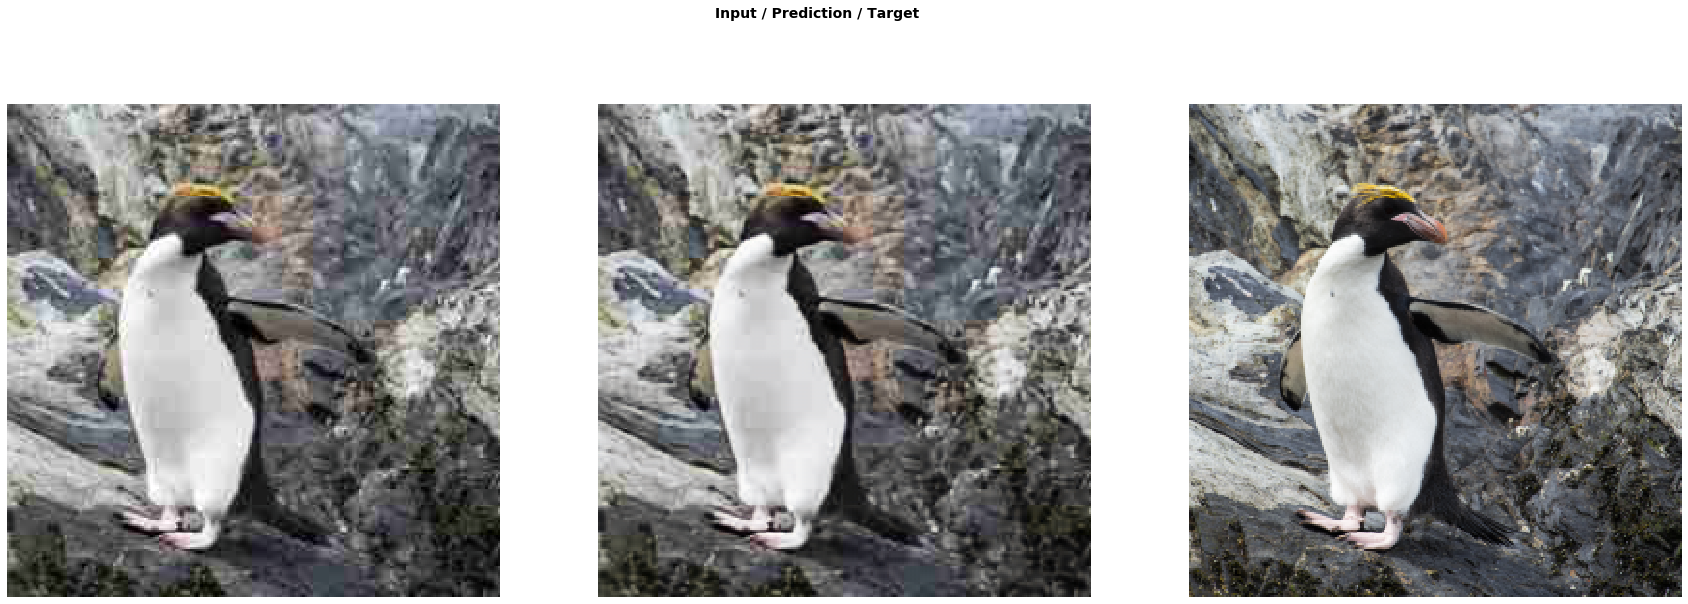

In [10]:
do_fit(learn_gen, 5, gen_name+"_256px_0", slice(lr*10))

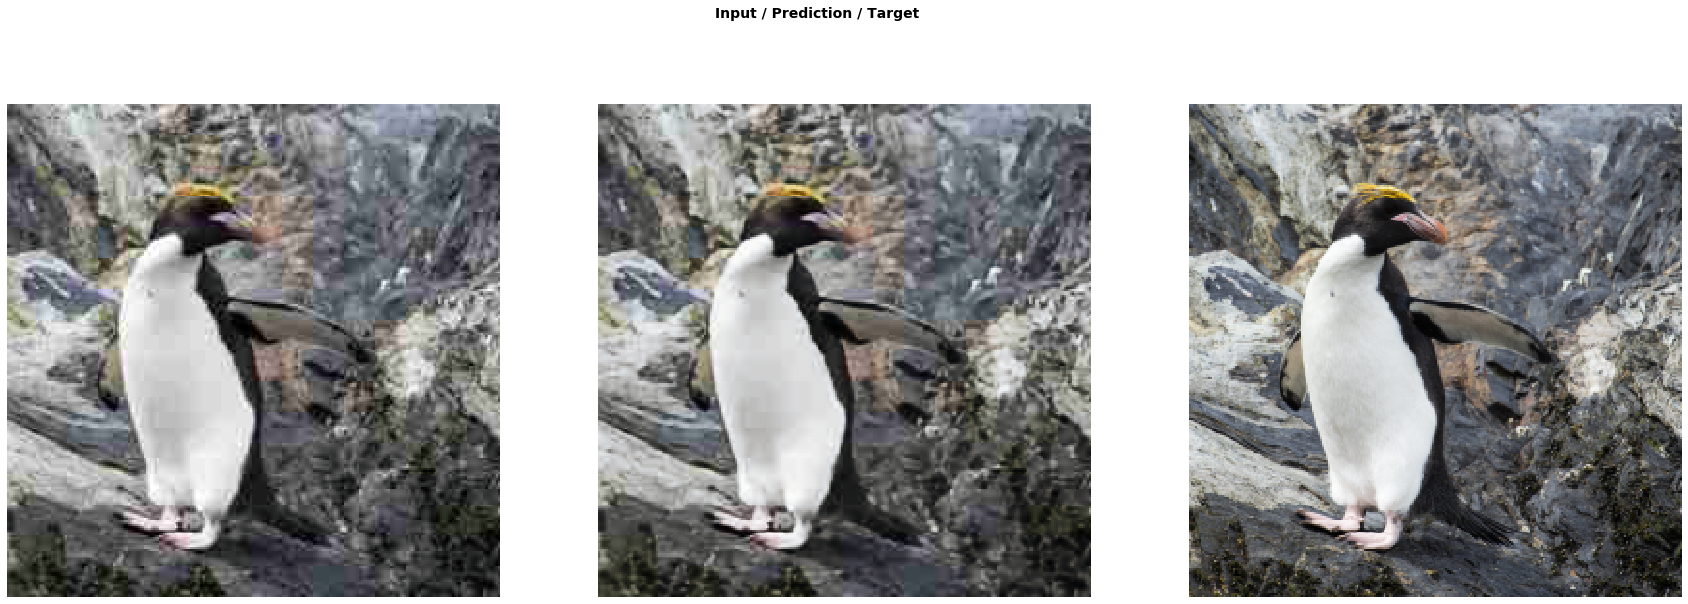

In [11]:
do_fit(learn_gen, 5, gen_name+"_256px_1", slice(lr))

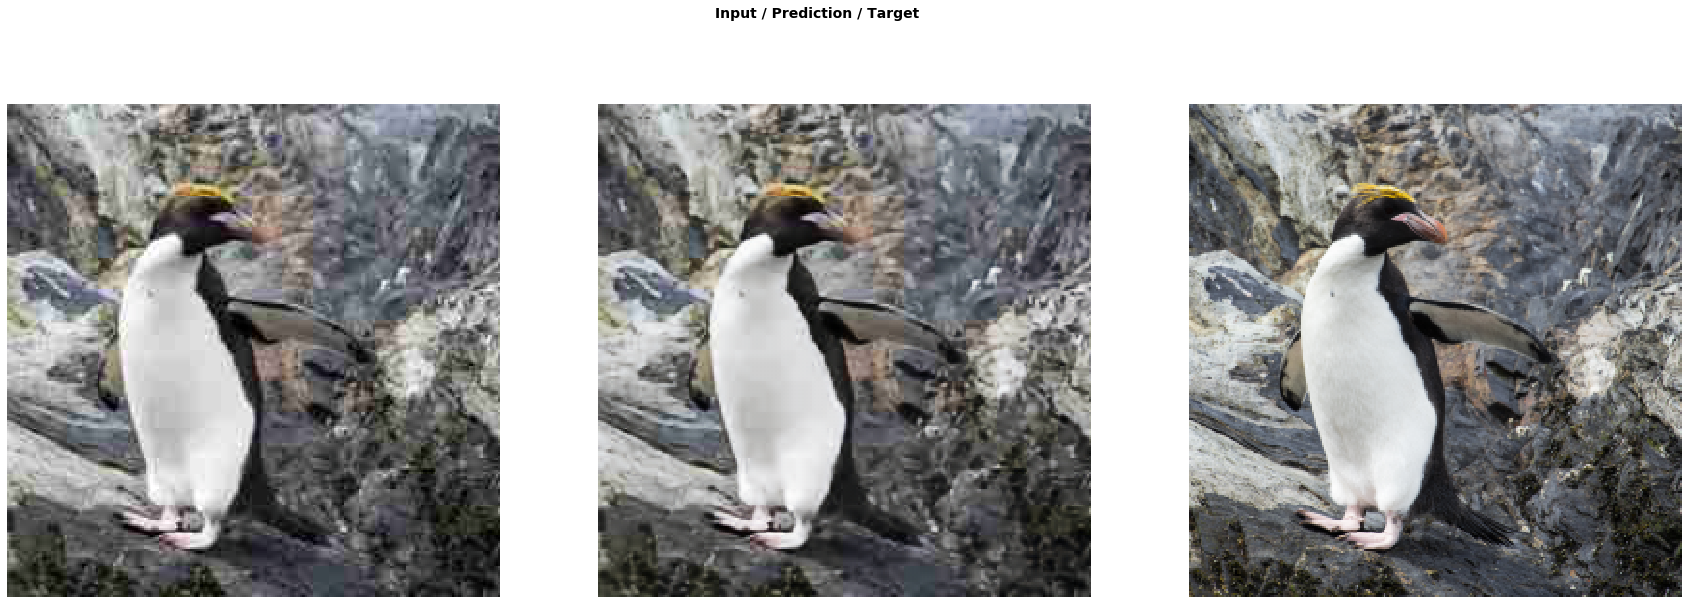

In [11]:
do_fit(learn_gen, 5, gen_name+"_256px_1", slice(1e-4))

In [10]:
learn_gen.load("/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/unet_superRes_mobilenetV3_MSE_gen_256px_1")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: dataset/DIV2K_train_LR_256_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: dataset/DIV2K_train_LR_256_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

In [12]:
learn_gen.unfreeze()

In [ ]:
do_fit(learn_gen, 5, gen_name+"_256px_2", slice(1e-4))

# 512px

In [16]:
bs=3
sz=512
epochs = 1

In [17]:
data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

In [18]:
learn_gen.data = data_gen
learn_gen.freeze()
gc.collect()

42

In [15]:
learn_gen.load("/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/unet_superRes_mobilenetV3_MSE_gen_256px_1")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


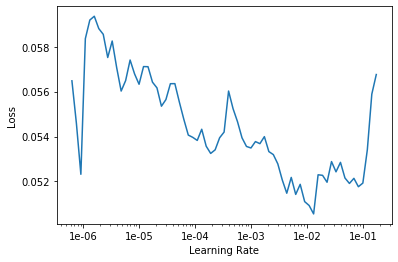

In [16]:
learn_gen.lr_find()
learn_gen.recorder.plot()

Upsize to gen_512


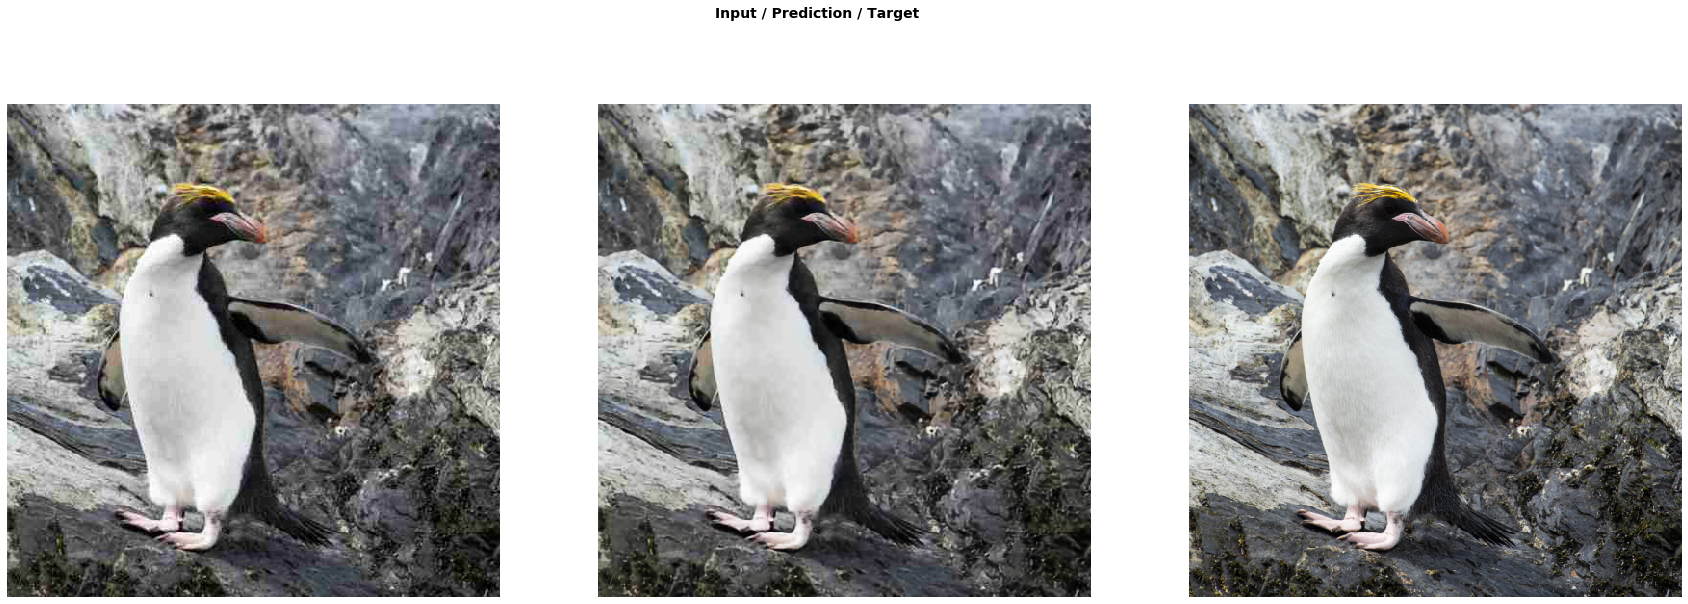

In [19]:
print("Upsize to gen_512")

do_fit(learn_gen, 3, gen_name+"_512px_0", slice(1e-3))

Upsize to gen_512


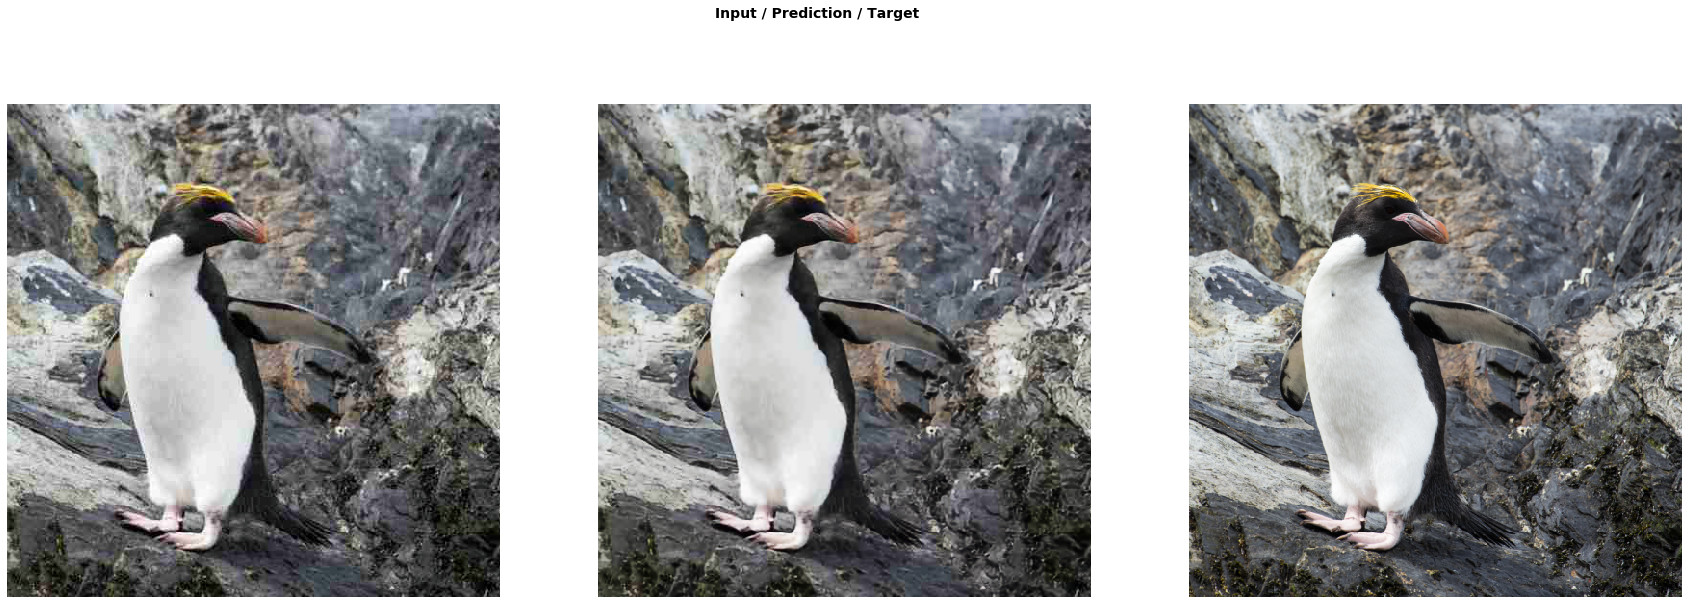

In [20]:
print("Upsize to gen_512")

do_fit(learn_gen, 3, gen_name+"_512px_0", slice(1e-4))

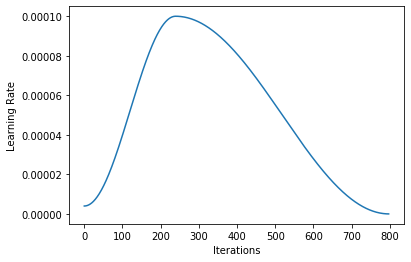

In [21]:
learn_gen.recorder.plot_lr()

In [22]:
learn_gen.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


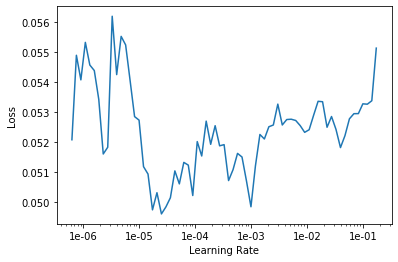

In [23]:
learn_gen.lr_find()
learn_gen.recorder.plot()

In [ ]:
do_fit(learn_gen, 3, gen_name+"_512px_1", 1e-5, pct_start=1e-3)

# Validation

In [9]:
bs=2
sz=512
epochs = 1

In [10]:
data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

In [11]:
path_lowRes_512

PosixPath('dataset/DIV2K_train_LR_512_QF20')

In [12]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [13]:
learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())
learn_gen.metrics.append(LPIPS_Metric_gen())
learn_gen.metrics.append(LPIPS_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [14]:
learn_gen.load("/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/unet_superRes_mobilenetV3_MSE_gen_512px_1")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

In [15]:
learn_gen.metrics

[SSIM_Metric_gen,
 SSIM_Metric_input,
 LPIPS_Metric_gen,
 LPIPS_Metric_input,
 BRISQUE_Metric_gen,
 BRISQUE_Metric_input,
 BRISQUE_Metric_target,
 NIQE_Metric_gen,
 NIQE_Metric_input,
 NIQE_Metric_target]

In [16]:
val = learn_gen.validate()

In [17]:
for name, m in zip(learn_gen.metrics, val[1:]):
    if isinstance(m, torch.Tensor):
        print(name, m.item())
    else:
        print(name, m)

SSIM_Metric_gen 0.7293819189071655
SSIM_Metric_input 0.7075174450874329
LPIPS_Metric_gen 0.16619916260242462
LPIPS_Metric_input 0.1764998584985733
BRISQUE_Metric_gen 88.91458925118474
BRISQUE_Metric_input 87.3549426119021
BRISQUE_Metric_target 85.32215693738695
NIQE_Metric_gen 17.823349
NIQE_Metric_input 17.860744
NIQE_Metric_target 15.693551


# Test

In [18]:
bs=1
sz=512
epochs = 1

In [19]:
path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
size=( 512, 680)

data_1k = (ImageImageList.from_folder(path_lowRes_512, presort=True).split_by_idxs(
            train_idx=list(range(0, 800)), valid_idx=list(range(800, 900)))
          .label_from_func(lambda x: path_fullRes/x.name.replace(".jpg", ".png"))
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_1k.c = 3

In [20]:
learn_gen = gen_learner_wide(data=data_1k,
                             gen_loss=loss_func,
                             arch = geffnet.mobilenetv3_rw,
                             nf_factor=nf_factor)

In [25]:
learn_gen.load("/data/students_home/fmameli/repos/Artifact_Removal_GAN/models/unet_superRes_mobilenetV3_MSE_gen_512px_1")

Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
y: ImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
y: ImageList
Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680),Image (3, 512, 680)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

In [21]:
fn = data_1k.valid_dl.x.items[2]; fn

PosixPath('dataset/DIV2K_train_LR_512_QF20/0803.jpg')

In [26]:
img = open_image(fn); print(img.shape)
p,img_hr,b = learn_gen.predict(img)

torch.Size([3, 512, 680])


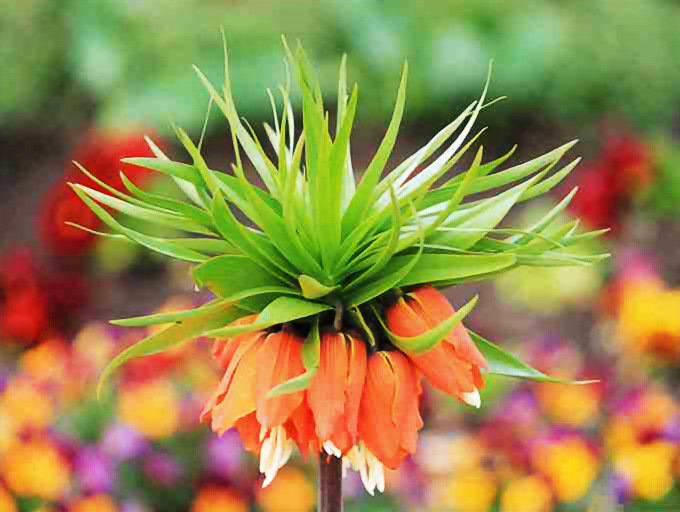

In [27]:
p

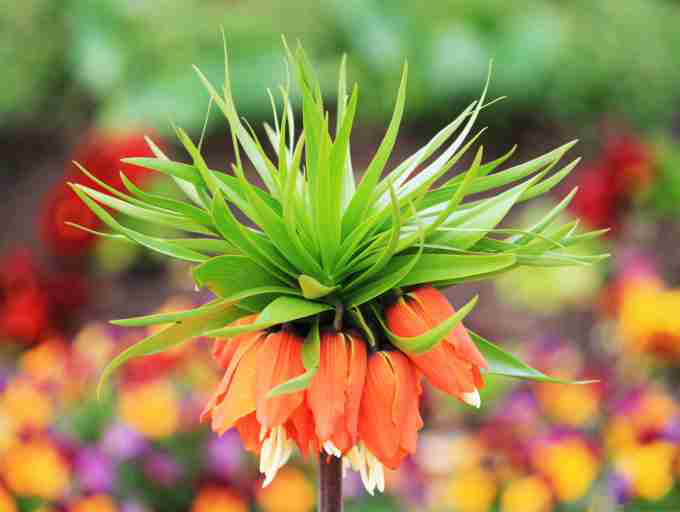

In [24]:
img

In [21]:
p.save('output_imgs/flower_512_MSE.png')

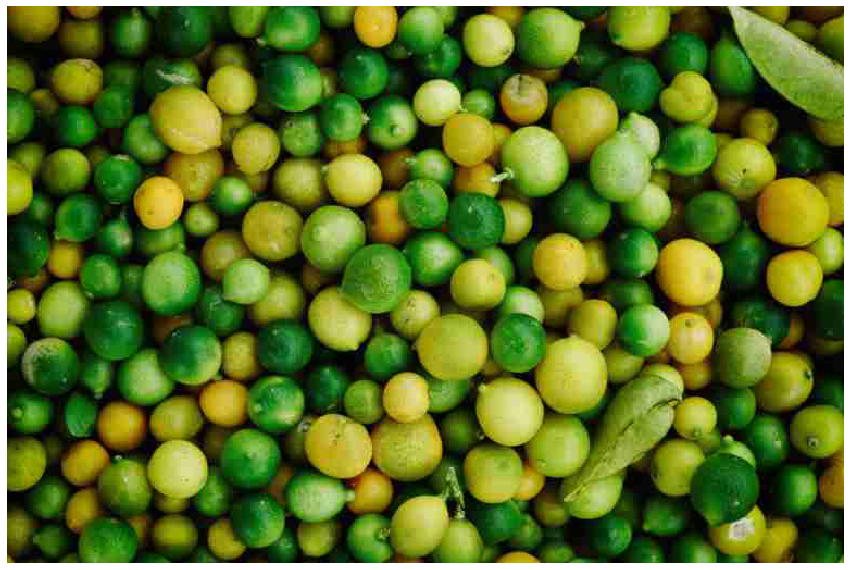

In [41]:
show_image(img, figsize=(15,15), interpolation='nearest');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


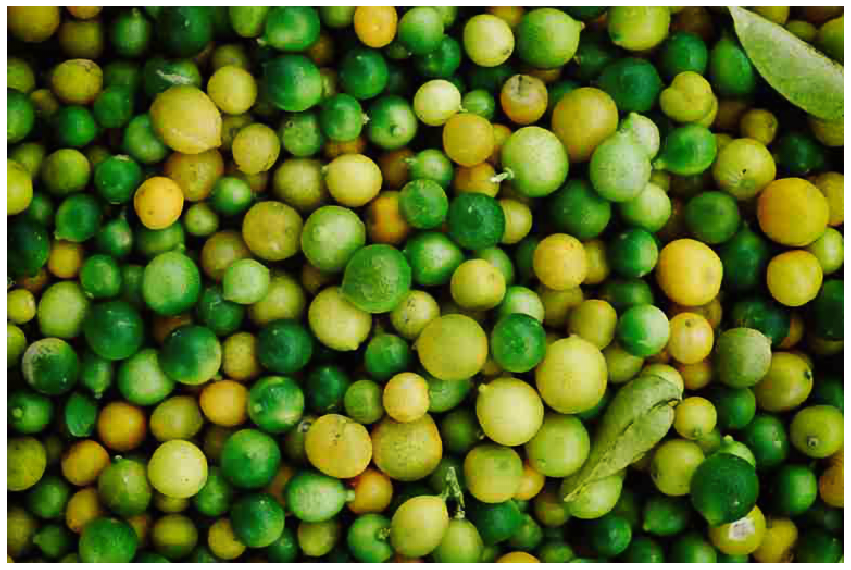

In [42]:
Image(img_hr).show(figsize=(15,15))